<a href="https://colab.research.google.com/github/MuradovMaks/TimeSeries_and_autocorrelation/blob/main/%D0%92%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5_%D1%80%D1%8F%D0%B4%D1%8B_%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Работа с массивами
import numpy as np

# Работа с таблицами
import pandas as pd

# Построение моделей нейронных сетей
from keras.models import Sequential, Model

# Слои
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization
from keras.layers import Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D
from keras.layers import MaxPooling1D, RepeatVector

# Оптимизаторы
from keras.optimizers import Adam

# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Нормировка
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Отрисовка графиков
import matplotlib.pyplot as plt
%matplotlib inline

# Назначение размера и стиля графиков по умолчанию
from pylab import rcParams
plt.style.use('ggplot')
rcParams['figure.figsize'] = (14, 7)

# Отключение лишних предупреждений
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/AAPL.csv
price = pd.read_csv('./AAPL.csv',index_col='Date',usecols=['Adj Close','Volume','Date'],parse_dates=['Date'])
price.head()

--2024-12-11 11:58:13--  https://storage.yandexcloud.net/academy.ai/AAPL.csv
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186539 (182K) [text/csv]
Saving to: ‘AAPL.csv.3’

AAPL.csv.3          100%[===================>] 182.17K   335KB/s    in 0.5s    

2024-12-11 11:58:15 (335 KB/s) - ‘AAPL.csv.3’ saved [186539/186539]



,Adj Close,Volume
Date,,
2014-01-02,17.296652,234684800
2014-01-03,16.916719,392467600
2014-01-06,17.008968,412610800
2014-01-07,16.887323,317209200
2014-01-08,16.994270,258529600


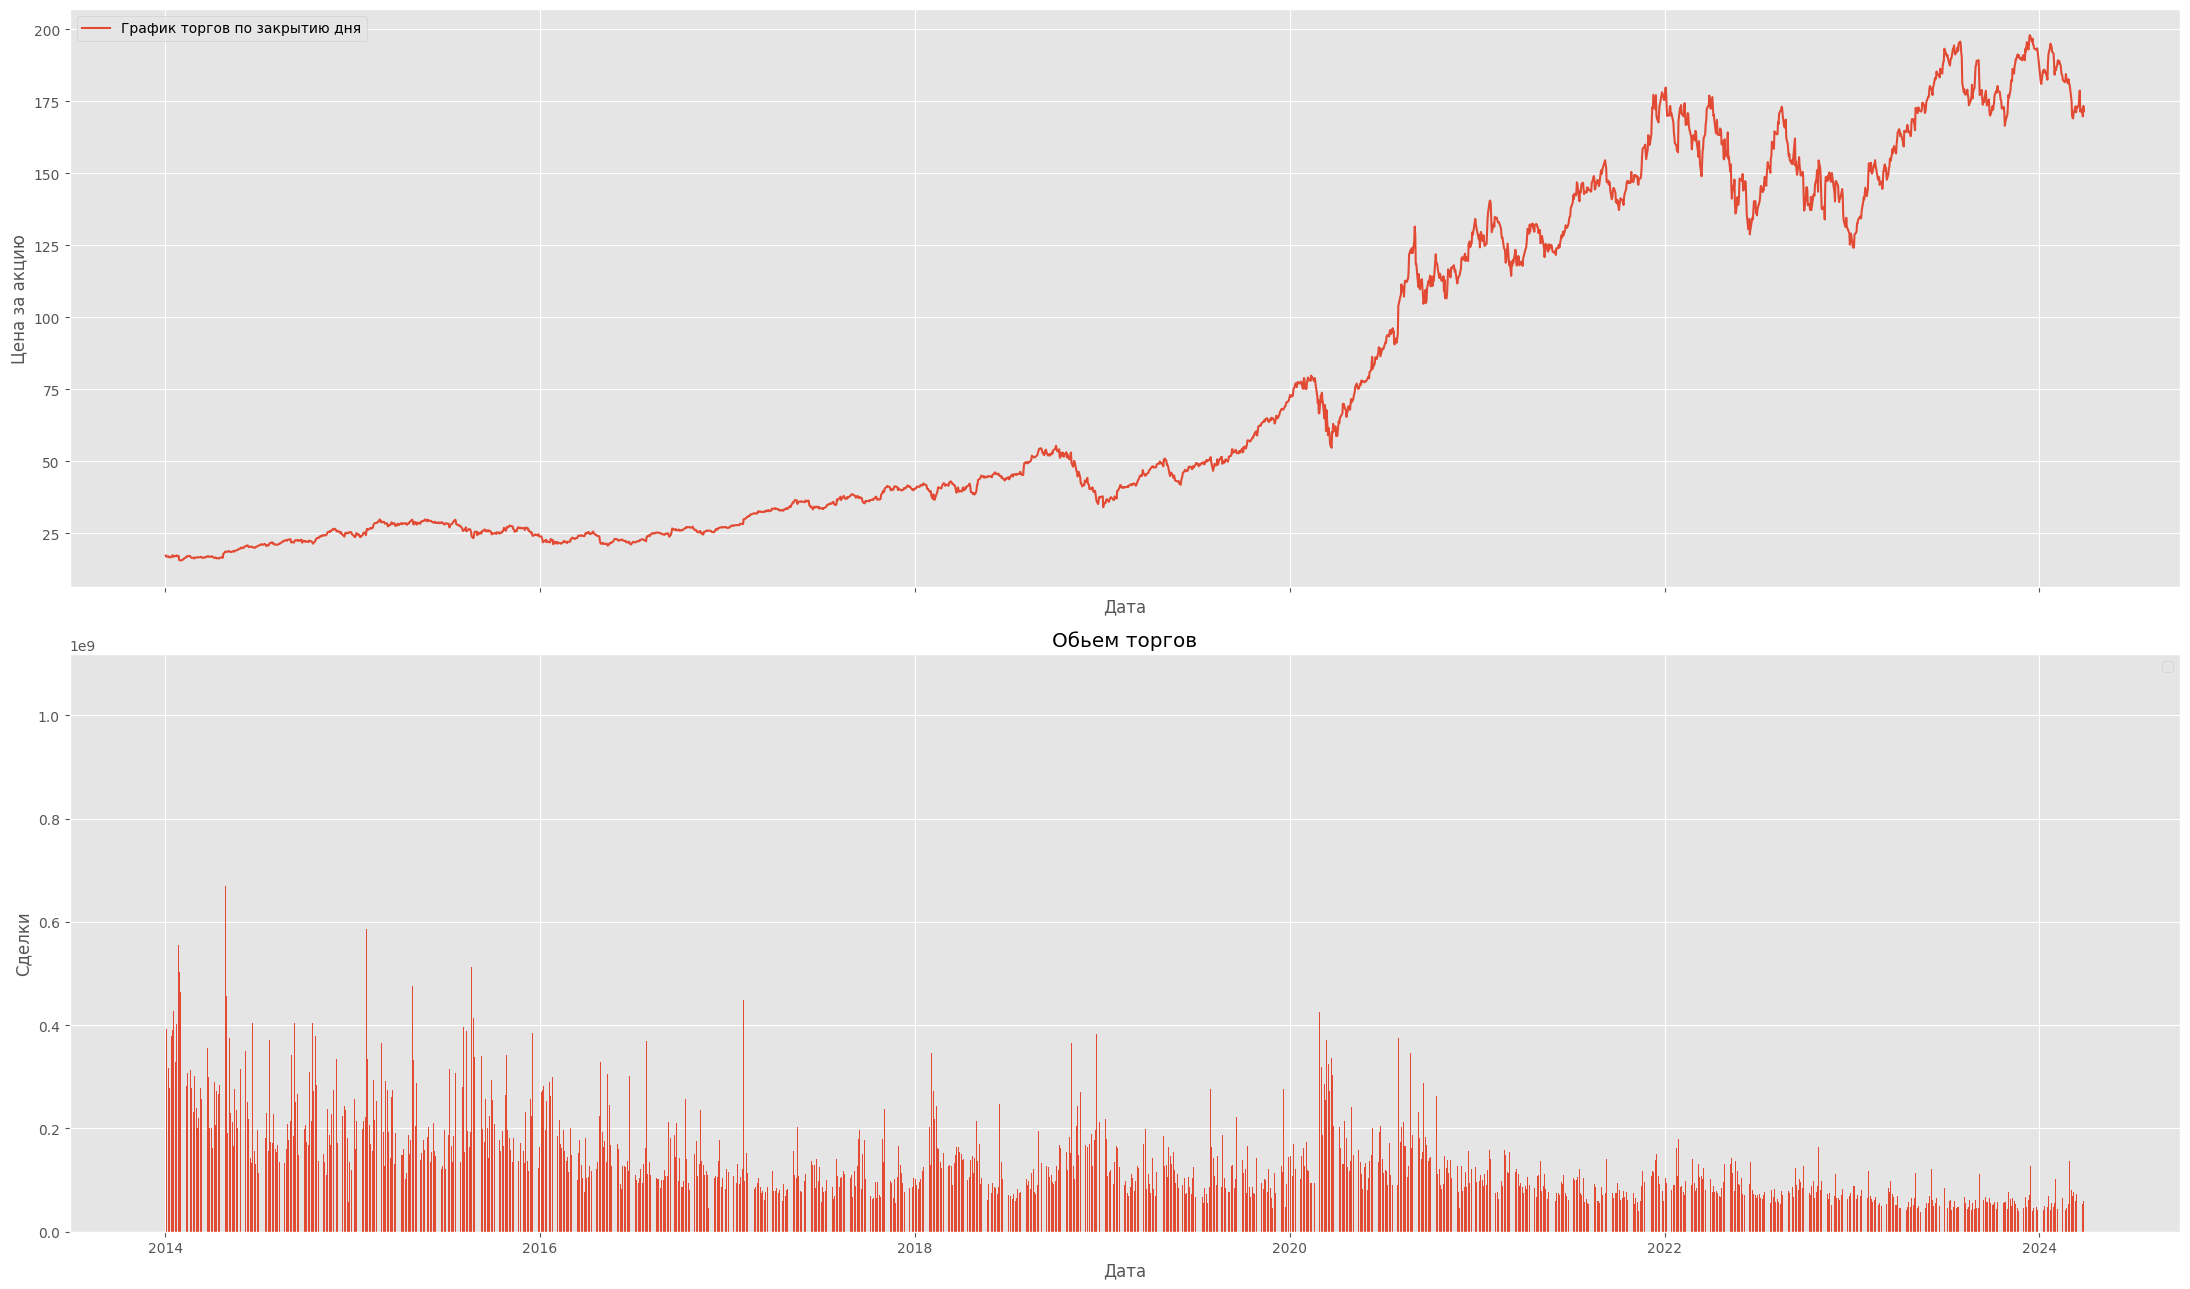

In [ ]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(22,13),sharex=True)

ax1.plot(price.index,price['Adj Close'],label='График торгов по закрытию дня')
ax1.set(xlabel='Дата')
ax1.set(ylabel='Цена за акцию')
ax1.legend()

ax2.bar(price.index,price['Volume'])
ax2.set(title='Обьем торгов')
ax2.set(xlabel='Дата')
ax2.set(ylabel='Сделки')
ax2.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Простая последовательность
series = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# параметры генератора
n_input = 2
batch_size = 10

generator = TimeseriesGenerator(series, series, length=n_input, batch_size=batch_size)

# Число сгенерированных примеров
print('Число примеров: %d' % len(generator))

# Вывод для каждого примера
for i in range(len(generator)):
	x, y = generator[i]

	print('%s => %s' % (x, y))

Число примеров: 1
[[1 2]
 [2 3]
 [3 4]
 [4 5]
 [5 6]
 [6 7]
 [7 8]
 [8 9]] => [ 3  4  5  6  7  8  9 10]


In [ ]:
price.drop(columns=['Volume'],inplace=True)

In [ ]:
train_data = price[:'2023-01-10']
test_data = price['2023-01-20':]

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [ ]:
print(f'Тренировочные данные: {scaled_train_data.shape}')
print(f'Тестовые данные: {scaled_test_data.shape}')

Тренировочные данные: (2272, 1)
Тестовые данные: (299, 1)


In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
n_input = 14
n_features = 1
batch_size = 2

generator  = TimeseriesGenerator(scaled_train_data,scaled_train_data,length=n_input,batch_size=batch_size)
print(f'Форма обучающего пакета {generator[0][0].shape},y={generator[0][1].shape}')

Форма обучающего пакета (2, 14, 1),y=(2, 1)


In [ ]:
validator = TimeseriesGenerator(scaled_test_data,scaled_test_data,length=n_input,batch_size=batch_size)
print(f'Форма валидационного пакета {validator[0][0].shape},y = {validator[0][1].shape}')

Форма валидационного пакета (2, 14, 1),y = (2, 1)


In [ ]:
tester = TimeseriesGenerator(scaled_test_data,scaled_test_data,length=n_input,batch_size=scaled_test_data.shape[0])
x_test, y_test = tester[0]
print(f'Форма тестового пакета {tester[0][0].shape},y = {tester[0][1].shape}')

Форма тестового пакета (285, 14, 1),y = (285, 1)


In [ ]:
#Вспомогательные функции

def history_plot(history,title):
  fig = plt.figure(figsize=(14,7))
  plt.plot(history.history['loss'],label='Потери на обучающей выборке')
  plt.plot(history.history['val_loss'],label='Потери на валидационной выборке')
  plt.title(f'Процесс обучения. {title}')
  fig.gca().xaxis.get_major_locator().set_params(integer=True)
  plt.xlabel(f'Эпоха')
  plt.ylabel(f'Ошибка')
  plt.legend()
  plt.show()

def correlate(a,b):
  return np.corrcoef(a,b)[0,1]

#Показывает базовый график и прогнозный
def show_predict(x,y_pred,y_true, title=''):
  fig = plt.figure(figsize=(12,8))
  pred = y_pred.shape[0]
  trues = y_true.shape[0]

  plt.plot(x.index[1:pred],y_pred[1:],label=f'Прогноз')
  plt.plot(x.index[1:trues],y_true[:-1],label=f'Реальная метка')
  plt.title(title)

  fig.gca().xaxis.get_major_locator().set_params(integer=True)
  plt.xlabel('Дата')
  plt.ylabel('Цена за акцию')
  plt.legend()
  plt.show()

# Функция расчета предсказания. Т.к мы применили к данным Scaled ,то для нормально представления применим функцию inverseTransform что вернуть обратно изначальные данные

def get_pred(model,x_test,y_test,y_scaler):
  y_pred_unscal = y_scaler.inverse_transform(model.predict(x_test))
  y_test_unscal = y_scaler.inverse_transform(y_test)

  return y_pred_unscal,y_test_unscal

def show_corr(y_pred,y_true,title='',break_step=30):
  y_len = y_true.shape[0]
  steps = range(1,np.min([y_len + 1,break_step+1]))

  #Обычная корреляцие между настоящим и предсказываемым результатом с разным временным смещением

  cross_corr = [correlate(y_true[:-step,0],y_pred[step:,0]) for step in steps]
  auto_corr = [correlate(y_true[:-step,0],y_true[step:,0])for step in steps]

  plt.plot(steps,cross_corr,label=f'Прогноз')
  plt.plot(steps,auto_corr,label=f'Эталон')
  plt.title(title)

  plt.xticks(steps)
  plt.xlabel('Шаги смещения')
  plt.ylabel('Коэфф. кореляции')
  plt.legend()
  plt.show()

In [ ]:
model_dense = Sequential()
model_dense.add(Dense(50,input_shape=generator[0][0].shape[1:],activation='relu'))
model_dense.add(Flatten())
model_dense.add(Dense(30,activation='linear'))
model_dense.add(Dropout(0.5))
model_dense.add(Dense(n_features,activation='linear'))
model_dense.compile(optimizer='adam',loss='mse')
model_dense.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_53 (Dense)                     │ (None, 14, 50)              │             100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_22 (Flatten)                 │ (None, 700)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 30)                  │          21,030 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,161 (82.66 KB)

 Trainable params: 21,161 (82.66 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(generator[0][0].shape)

(2, 14, 1)


In [ ]:
model_dense.fit(generator,epochs=20,validation_data=validator)

Epoch 1/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0272 - val_loss: 0.0016
Epoch 2/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0070 - val_loss: 0.0020
Epoch 3/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0061 - val_loss: 0.0011
Epoch 4/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0054 - val_loss: 9.2069e-04
Epoch 5/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0053 - val_loss: 0.0013
Epoch 6/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0041 - val_loss: 0.0138
Epoch 7/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0042 - val_loss: 0.0099
Epoch 8/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0043 - val_loss: 6.5751e-04
Epoch 9/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0042 - val_loss: 9.2037e-04
Epoch 10/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0044 - val_loss: 0.0096
Epoch 11/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0042 - val_loss: 5.2223e-04
Epoch 12/20
11

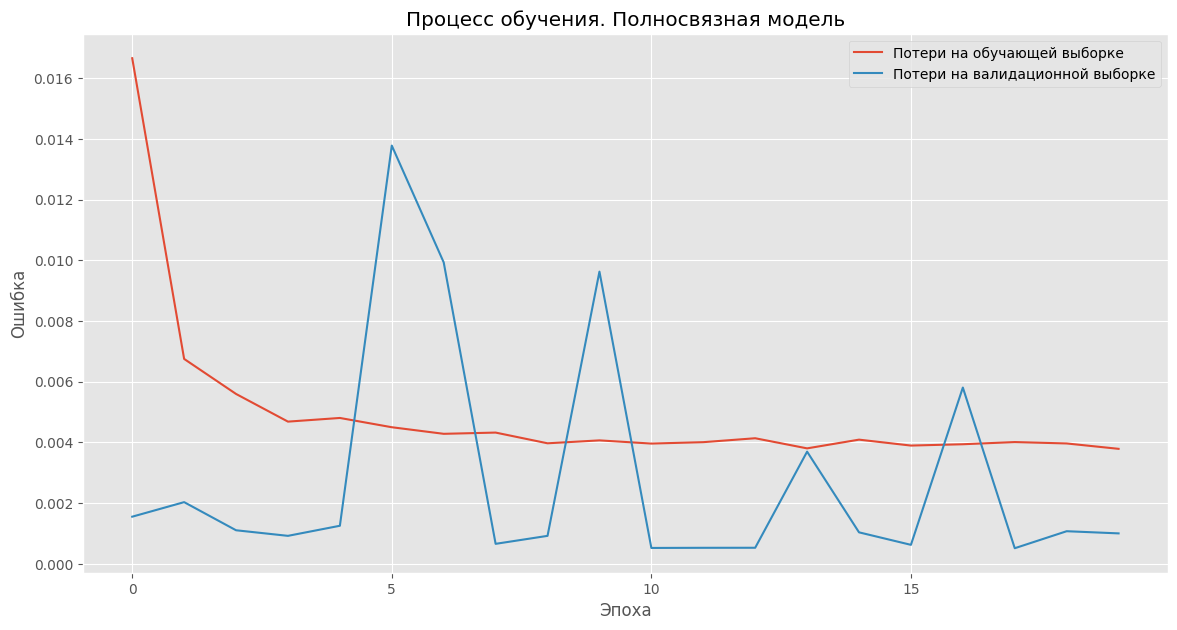

In [ ]:
history_plot(model_dense.history,title='Полносвязная модель')

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


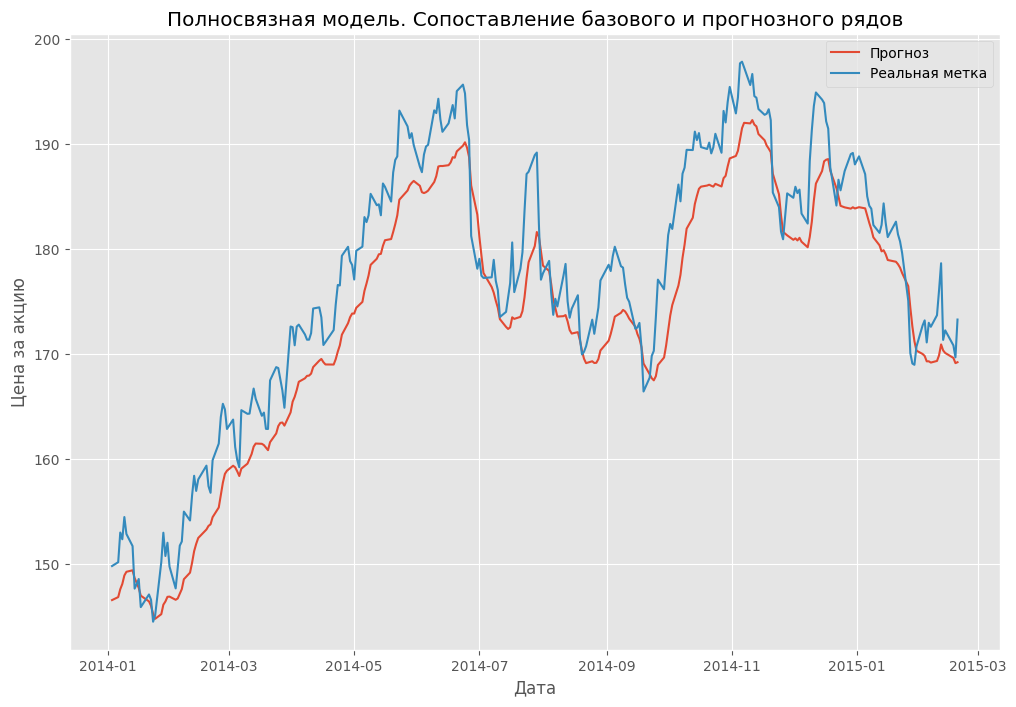

In [ ]:
y_pred,y_true = get_pred(model_dense,x_test,y_test,scaler)
show_predict(price,y_pred,y_true,title='Полносвязная модель. Сопоставление базового и прогнозного рядов')

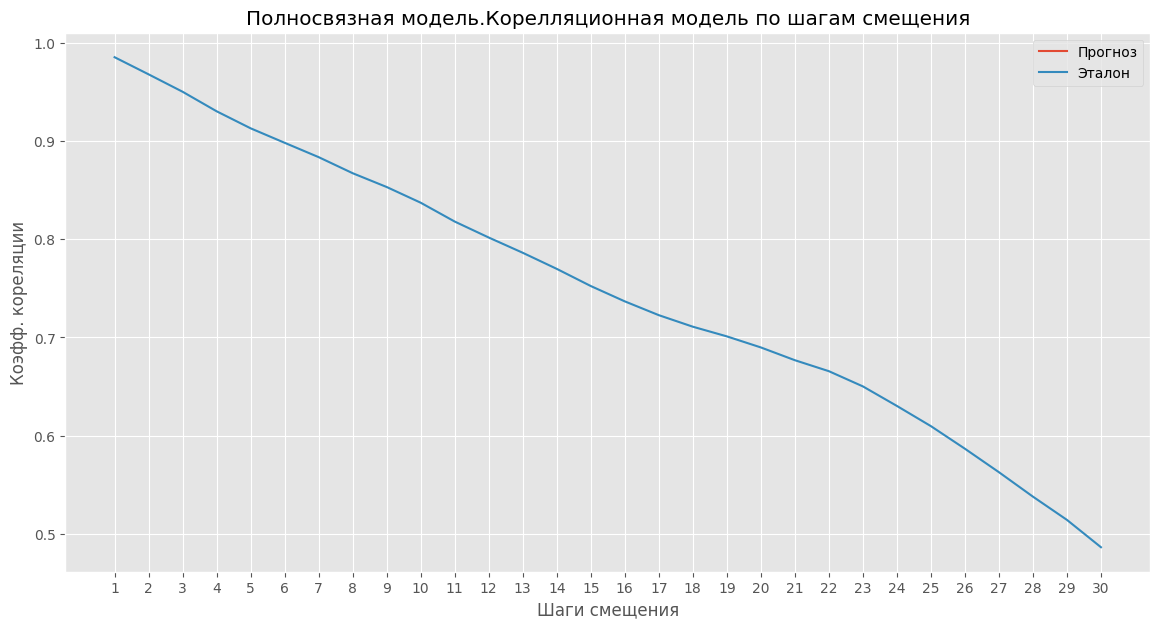

In [ ]:
show_corr(y_pred,y_true,'Полносвязная модель.Корелляционная модель по шагам смещения')

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(50,activation='relu',input_shape=generator[0][0].shape[1:]))
lstm_model.add(Dense(10,activation='relu'))
lstm_model.add(Dense(n_features))
lstm_model.compile(optimizer='adam',loss='mse')
lstm_model.fit(generator,epochs=20,validation_data=validator)

Epoch 1/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0376 - val_loss: 0.0034
Epoch 2/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 5.5776e-04 - val_loss: 0.0053
Epoch 3/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 5.1874e-04 - val_loss: 7.8528e-04
Epoch 4/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 4.3010e-04 - val_loss: 9.5026e-04
Epoch 5/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 3.5114e-04 - val_loss: 0.0027
Epoch 6/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 6.4272e-04 - val_loss: 3.5976e-04
Epoch 7/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 3.8233e-04 - val_loss: 0.0038
Epoch 8/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 2.7885e-04 - val_loss: 2.9768e-04
Epoch 9/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 2.8455e-04 - val_loss: 3.1546e-04
Epoch 10/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 2.8651e-04 - val_loss: 9.3189e-04
Epoch 11/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 11s

In [ ]:
lstm_model.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 10)                  │             510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,765 (127.99 KB)

 Trainable params: 10,921 (42.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,844 (85.33 KB)

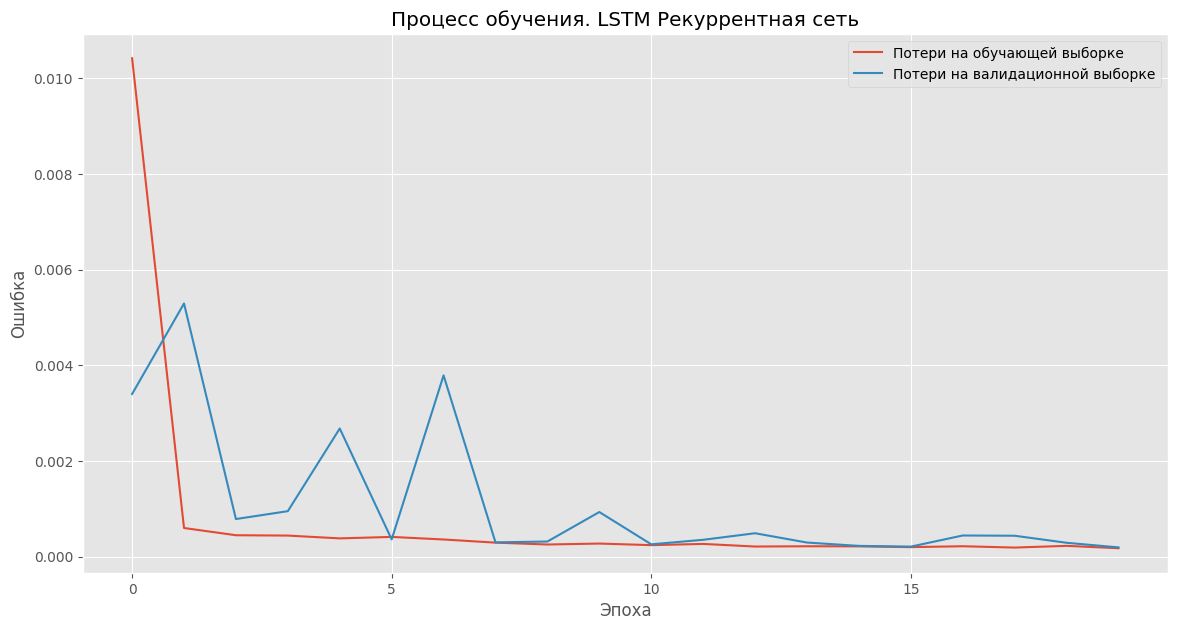

In [ ]:
history_plot(lstm_model.history,'LSTM Рекуррентная сеть')

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


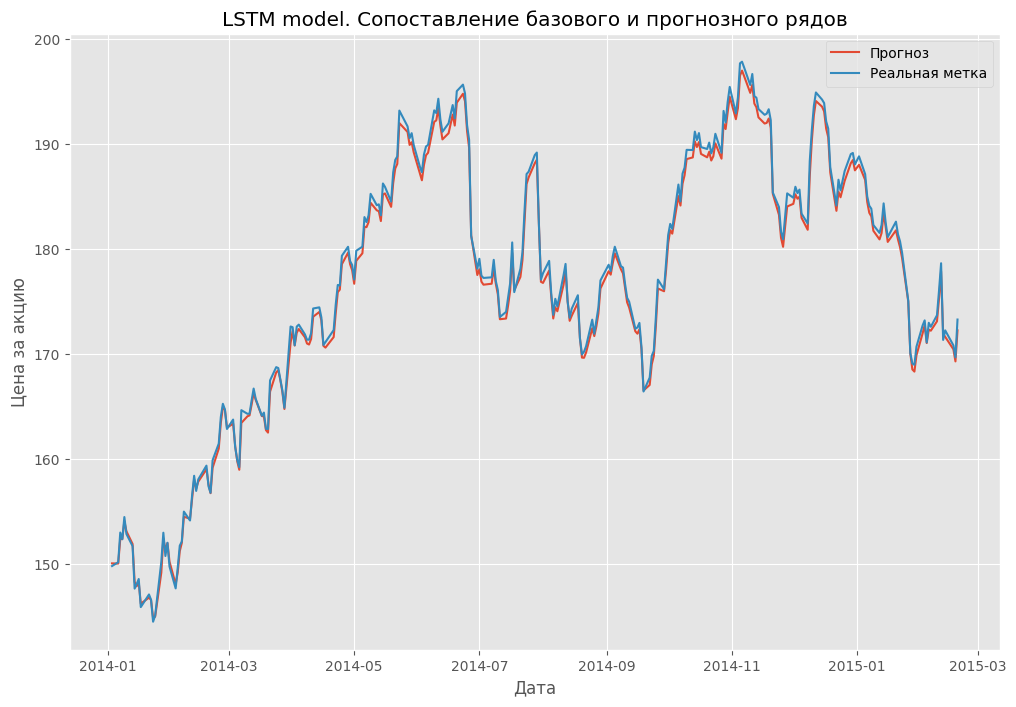

In [ ]:
y_pred,y_true = get_pred(lstm_model,x_test,y_test,scaler)
show_predict(price,y_pred,y_true,'LSTM model. Сопоставление базового и прогнозного рядов')

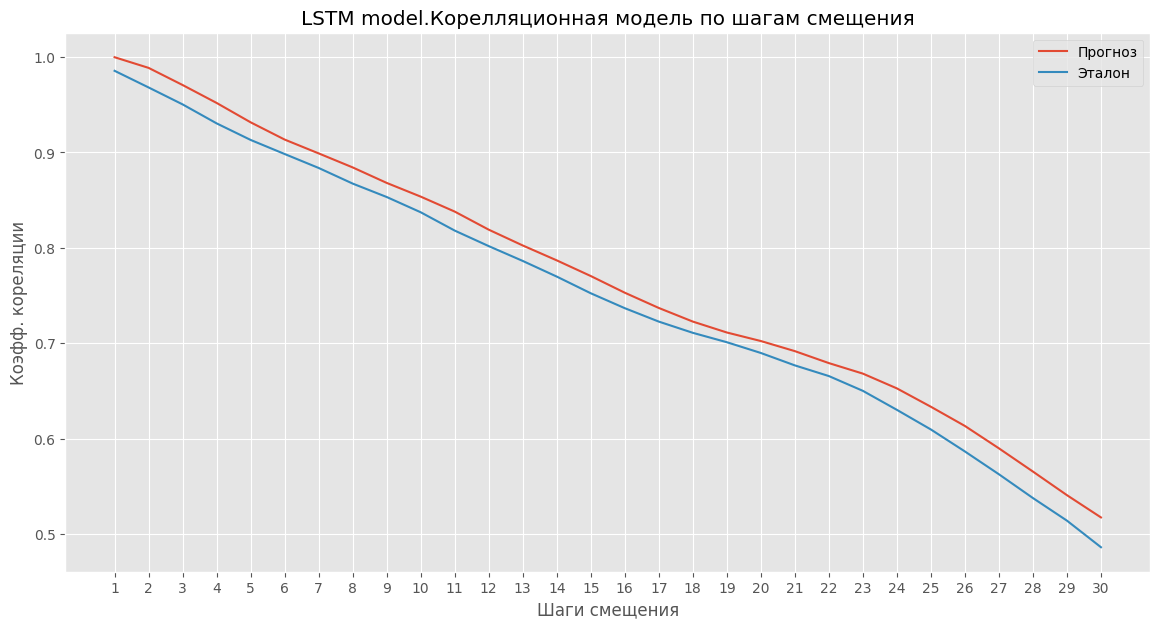

In [ ]:
show_corr(y_pred,y_true,'LSTM model.Корелляционная модель по шагам смещения')

In [ ]:
from tensorflow.keras.regularizers import l1,l2
model_conv = Sequential()
model_conv.add(Conv1D(64,4,input_shape=generator[0][0].shape[1:]))
model_conv.add(Conv1D(32,4,activation='relu'))
model_conv.add(MaxPooling1D())
model_conv.add(Dense(30,activation='relu'))
model_conv.add(Flatten())
model_conv.add(Dense(n_features,activation='linear'))

model_conv.compile(optimizer='adam',loss='mse')
model_conv.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_71 (Conv1D)                   │ (None, 11, 64)              │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_72 (Conv1D)                   │ (None, 8, 32)               │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_26 (MaxPooling1D)      │ (None, 4, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 4, 30)               │             990 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_24 (Flatten)                 │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,655 (37.71 KB)

 Trainable params: 9,655 (37.71 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_conv.fit(generator,epochs=20,validation_data=validator)

Epoch 1/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0062 - val_loss: 0.0050
Epoch 2/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0011 - val_loss: 0.0096
Epoch 3/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 4/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0013 - val_loss: 0.0156
Epoch 5/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 8.6004e-04 - val_loss: 0.0032
Epoch 6/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 9.4645e-04 - val_loss: 0.0028
Epoch 7/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 4.5553e-04 - val_loss: 3.7784e-04
Epoch 8/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.7326e-04 - val_loss: 0.0047
Epoch 9/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.5421e-04 - val_loss: 0.0031
Epoch 10/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 6.8141e-04 - val_loss: 0.0044
Epoch 11/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 5.8410e-04 - val_loss: 4.103

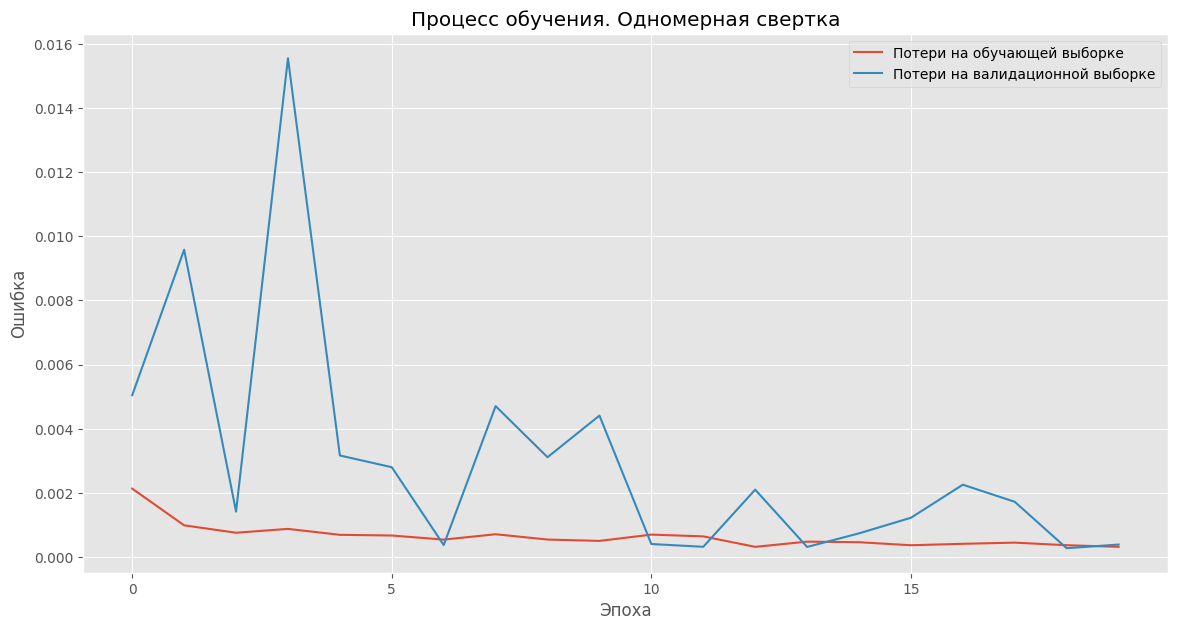

In [ ]:
history_plot(model_conv.history,'Одномерная свертка')

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


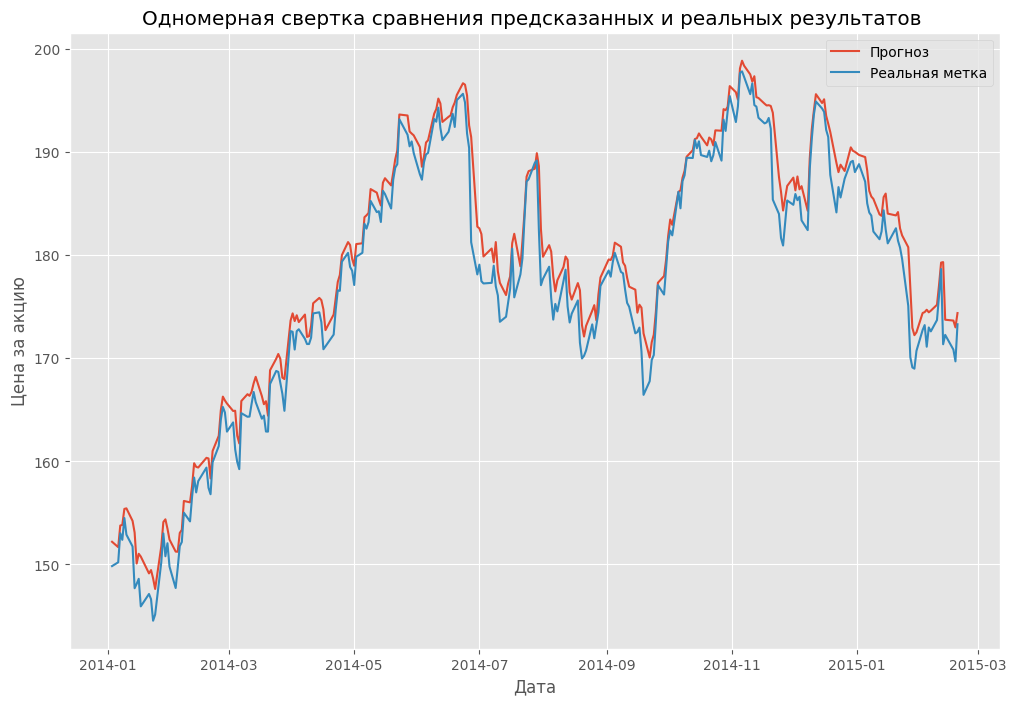

In [ ]:
y_pred,y_true = get_pred(model_conv,x_test,y_test,scaler)
show_predict(price,y_pred,y_true,'Одномерная свертка сравнения предсказанных и реальных результатов ')

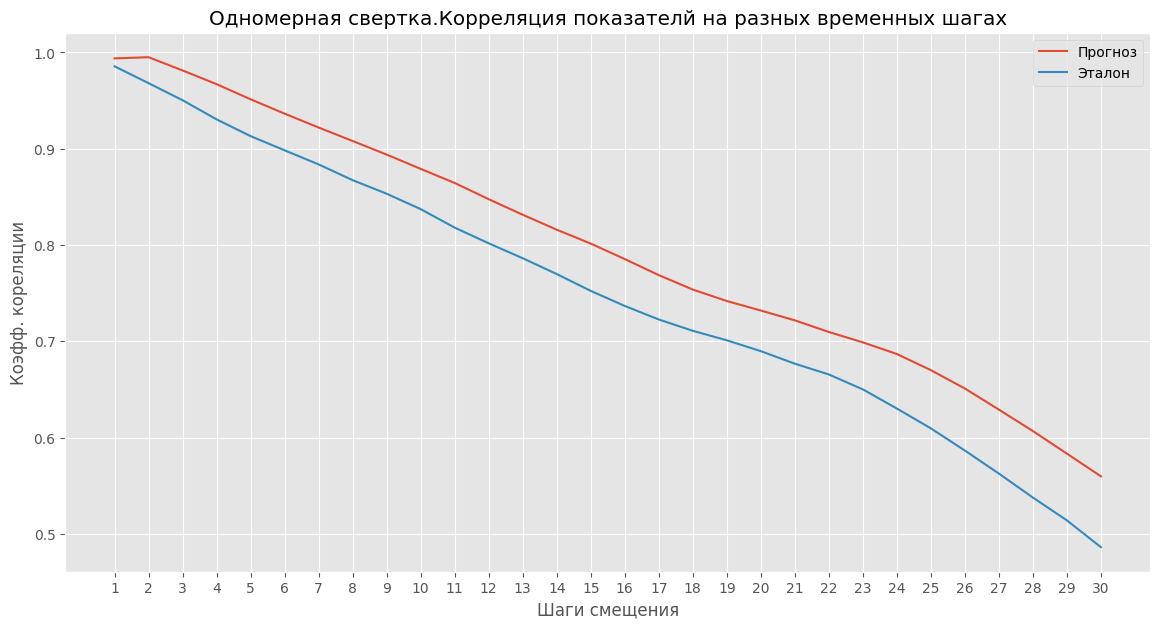

In [ ]:
show_corr(y_pred,y_true,'Одномерная свертка.Корреляция показателй на разных временных шагах')